# Ordinary Least Square

In [134]:
%matplotlib inline

In [135]:
#Data processing
import numpy as np
import pandas as pd
from sklearn import preprocessing
import plotly.plotly as py
import plotly.figure_factory as ff
from scipy import stats
from sklearn.preprocessing import PolynomialFeatures

#Plotting
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import graphviz
import seaborn as sns; sns.reset_orig()
from Residual_Visualization import regression_residual_plots

#Machine Learning
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std


#Helpers
from sklearn import model_selection
from sklearn.pipeline import make_pipeline

/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning:


examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.

/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning:


The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.



In [136]:
df = pd.read_csv("/Users/duc_hoang/Box Sync/Fermilab Summer Research/Analysis_Scripts/Main data/Jesse+GA/GA_Jesse_with_group.csv",
                 index_col = 0)

In [137]:
df = df.drop('group', axis=1)
#Select out the healthy parts
df = df[df["final_accuracy"] >= 0.0465]

Text(0.5, 1.0, 'Transformed Accuracy')

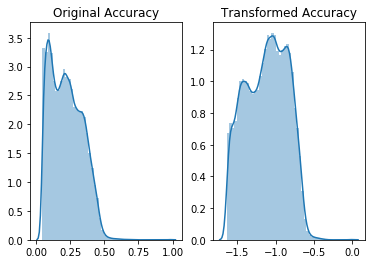

In [138]:
# normalize the exponential data with boxcox
normalized_accuracy = stats.boxcox(df["final_accuracy"])

# plot both together to compare
fig, ax=plt.subplots(1,2)
sns.distplot(df['final_accuracy'], ax=ax[0])
ax[0].set_title("Original Accuracy")
ax[0].set(xlabel='')
sns.distplot(normalized_accuracy[0], ax=ax[1])
ax[1].set_title("Transformed Accuracy")

In [139]:
df["transformed_accuracy"] = normalized_accuracy[0]

In [140]:
#Feature + target
X = df.drop(columns=['initial_accuracy','final_accuracy', 'genealogy',"transformed_accuracy"]) #Features
y = df["transformed_accuracy"]

#Extract initial feature names and index for later use
initial_feature_names = X.columns #Save the feature names
initial_index = X.index

In [141]:
def generate_feature_names(power,initial_feature_names,initial_index, transformed_data):
    """
    Since the fit_transform function does not automatically generate the feature names for the interaction term,
    this function creates a feature name list and append it to the the transformed features array.
    
    Arguments:
    power:                 -- numpy array of dimension (total number of regressors, initial number of regressors) 
                           -- indicates the power of each initial feature of each column of transformed_data 
    
    initial_feature_names: -- pandas index object 
                           -- contains original names of features before transformed
    
    initial_index:         -- pandas index object 
                           -- maintain index of transformed_data
                           
    transformed_data:      -- numpy array of transformed data including the interaction terms
    
    Returns: 
    new_dataframe -- pandas dataframe with the columns names for interaction terms 
    """
    new_feature_names = [] #to save all the new feature names
    
    #Loop through power to generate new feature names
    for i in range(power.shape[0]):
        feature_name = ''
        for j in range(len(initial_feature_names)):
            if power[i,j]: #If the feature should be included then add to feature names
                if not feature_name: #If feature name is still empty
                    feature_name += initial_feature_names[j]
                else:
                    feature_name = feature_name + "*" + initial_feature_names[j]
        #Add feature name to new list a the end
        new_feature_names.append(feature_name)

    new_dataframe = pd.DataFrame(transformed_data, columns=new_feature_names,index=initial_index)
    
    return new_dataframe

In [142]:
#Scale the inputs
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
scaler.fit(X)  
X = scaler.transform(X) 

In [143]:
poly = PolynomialFeatures(interaction_only = True, include_bias = False)
X = poly.fit_transform(X) #Create interaction terms 

In [144]:
#X now should be the new dataframe with columns name
X = generate_feature_names(poly.powers_,initial_feature_names,initial_index, X)

#Fit model
model = sm.OLS(y, X)

results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     transformed_accuracy   R-squared:                       0.961
Model:                              OLS   Adj. R-squared:                  0.961
Method:                   Least Squares   F-statistic:                     3527.
Date:                  Sun, 14 Jul 2019   Prob (F-statistic):               0.00
Time:                          11:57:54   Log-Likelihood:                 4712.8
No. Observations:                 70691   AIC:                            -8434.
Df Residuals:                     70195   BIC:                            -3887.
Df Model:                           496                                         
Covariance Type:              nonrobust                                         
==============================================================================================================================================
                                                                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------
avg_IP_neurons                                                                 2.9122      0.019    152.399      0.000       2.875       2.950
avg_IP_weights                                                                 0.0423      0.005      7.981      0.000       0.032       0.053
avg_concat_width                                                              -0.1586      0.004    -39.518      0.000      -0.166      -0.151
avg_grid_reduction_area_consecutive                                           -0.0439      0.009     -5.042      0.000      -0.061      -0.027
avg_grid_reduction_area_total                                                  0.0518      0.008      6.456      0.000       0.036       0.068
avg_grid_reduction_height_consecutive                                          0.0617      0.007      8.292      0.000       0.047       0.076
avg_grid_reduction_height_total                                               -0.2249      0.007    -31.453      0.000      -0.239      -0.211
avg_grid_reduction_width_consecutive                                          -0.0436      0.007     -6.310      0.000      -0.057      -0.030
avg_grid_reduction_width_total                                                -0.1368      0.007    -18.295      0.000      -0.151      -0.122
avg_num_conv_features                                                          0.1112      0.007     17.093      0.000       0.098       0.124
avg_ratio_features_to_depth                                                   -0.0685      0.007    -10.252      0.000      -0.082      -0.055
avg_ratio_features_to_kerArea                                                  0.0011      0.006      0.167      0.867      -0.011       0.014
avg_ratio_features_to_kerHeight                                                0.0283      0.004      6.391      0.000       0.020       0.037
avg_ratio_features_to_kerWidth                                                -0.1419      0.004    -38.432      0.000      -0.149      -0.135
avg_ratio_kerArea_to_depth                                                    -0.0353      0.004     -9.417      0.000      -0.043      -0.028
avg_ratio_kerHeight_to_depth                                                   0.0115      0.003      3.991      0.000       0.006       0.017
avg_ratio_kerWidth_to_depth                                                    0.0933      0.003     26.718      0.000       0.086       0.100
avg_stride_h                                                                   0.3412      0.011     29.763      0.000       0.319       0.364
avg_stride_w                                              

In [149]:
results.summary2().tables[1].sort_values(by = "P>|t|")[0:15]

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
avg_IP_neurons,2.912175,0.019109,152.399314,0.000000e+00,2.874722,2.949628
avg_concat_width,-0.158597,0.004013,-39.517649,0.000000e+00,-0.166463,-0.150731
num_pooling_layers,-2.584295,0.017765,-145.467838,0.000000e+00,-2.619115,-2.549475
avg_IP_neurons*num_pooling_layers,-1.134142,0.008052,-140.852387,0.000000e+00,-1.149924,-1.118360
avg_IP_neurons*num_conv_layers,-0.975854,0.006692,-145.834578,0.000000e+00,-0.988970,-0.962739
avg_IP_neurons*net_depth_avg,1.638811,0.010485,156.300963,0.000000e+00,1.618261,1.659362
num_conv_layers,-2.175961,0.015682,-138.757187,0.000000e+00,-2.206697,-2.145224
net_depth_avg,3.670505,0.024266,151.263436,0.000000e+00,3.622944,3.718065
avg_ratio_features_to_kerWidth,-0.141938,0.003693,-38.432248,0.000000e+00,-0.149177,-0.134699
avg_stride_w,0.324679,0.009619,33.754922,8.847834e-248,0.305826,0.343531


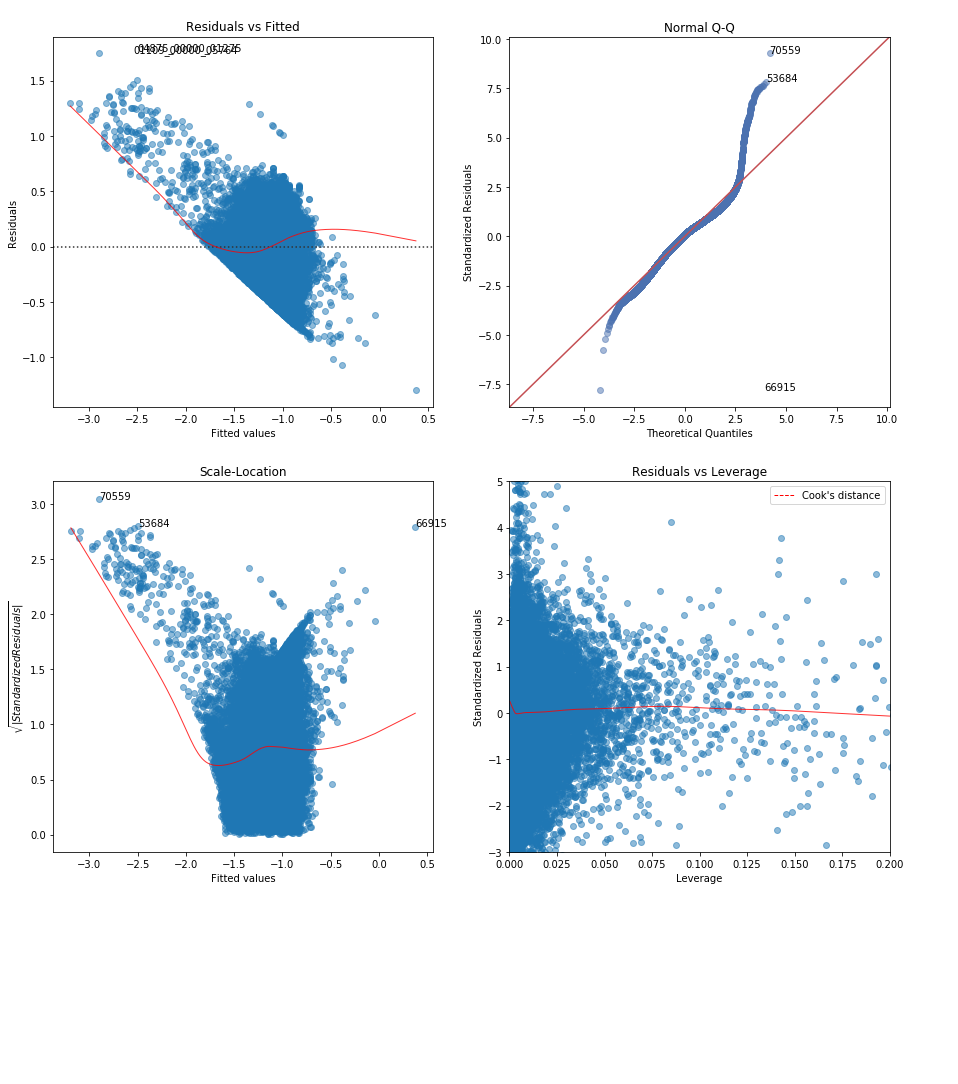

In [147]:
#Might be used to analyse the linear model
regression_residual_plots(results,'transformed_accuracy',df, size = [15,15])